run 50: Style Loss : 851.097168 Content Loss: 8.257166
run 100: Style Loss : 174.994797 Content Loss: 9.227022
run 150: Style Loss : 95.552376 Content Loss: 9.405127
run 200: Style Loss : 57.075138 Content Loss: 9.658175
run 250: Style Loss : 33.578716 Content Loss: 9.776722
run 300: Style Loss : 19.321568 Content Loss: 9.718706
run 350: Style Loss : 11.770870 Content Loss: 9.534132
run 400: Style Loss : 8.116463 Content Loss: 9.199121
run 450: Style Loss : 5.952736 Content Loss: 8.874566
run 500: Style Loss : 4.659664 Content Loss: 8.607878


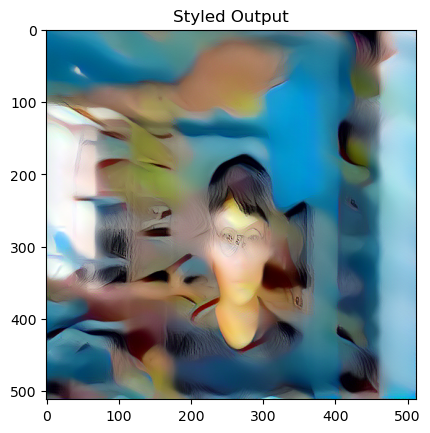

風格化圖片已儲存至 C:\Users\chenl\Desktop\styled_output.png


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy

# 設定設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 設定輸出圖像的大小
imsize = 512 if torch.cuda.is_available() else 256  # 可以調整為更高的解析度，例如 1024

# 圖像處理
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# 加載風格圖和內容圖
style_img = image_loader(r"C:\Users\chenl\Desktop\我的深度學習自學\Anime Style Transfer\anime-style-transfer\train\style\00000.png")  # 替換為您的風格圖片路徑
content_img = image_loader(r"C:\Users\chenl\Pictures\Camera Roll\WIN_20241104_01_28_52_Pro.jpg")  # 替換為您的內容圖片路徑

# 用於將 Tensor 轉為 PIL 圖像
unloader = transforms.ToPILImage()

# 顯示圖像
def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)

# 定義內容損失類
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# 計算 Gram 矩陣
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

# 定義風格損失類
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# 正規化層
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)
    
    def forward(self, img):
        return (img - self.mean) / self.std

# 構建模型
cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
            model.add_module(name, layer)
            if name in content_layers:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)
            if name in style_layers:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
            model.add_module(name, layer)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
            model.add_module(name, layer)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
            model.add_module(name, layer)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i + 1]
    return model, style_losses, content_losses

# 優化器
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

# 風格轉移
def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img, input_img, num_steps=500,
                       style_weight=1e7, content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    run = [0]
    
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = sum(sl.loss for sl in style_losses) * style_weight
            content_score = sum(cl.loss for cl in content_losses) * content_weight
            loss = style_score + content_score
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run {run[0]}: Style Loss : {style_score.item():4f} Content Loss: {content_score.item():4f}")
            return loss
        optimizer.step(closure)
    input_img.data.clamp_(0, 1)
    return input_img

# 運行風格轉移
input_img = content_img.clone()
output = run_style_transfer(
    cnn, cnn_normalization_mean, cnn_normalization_std, 
    content_img, style_img, input_img, 
    num_steps=500,  # 增加迭代次數
    style_weight=1e7,  # 強調風格特徵
    content_weight=1  # 保留內容結構
)

# 顯示結果
plt.figure()
imshow(output, title='Styled Output')

# 儲存結果
output_image_path = r"C:\Users\chenl\Desktop\styled_output.png"
output_image = transforms.ToPILImage()(output.squeeze(0).cpu())
output_image.save(output_image_path)
print(f"風格化圖片已儲存至 {output_image_path}")
